In [1]:
# This notebook is similar to another one, only matching gaussian_means are modified

!pip install open3d
!pip install faiss-gpu
!sudo apt-get install libsuitesparse-dev
!pip install theseus-ai

import os
from typing import Dict, Tuple, List, Union
from pathlib import Path
import math
import yaml
import gc

import numpy as np
from matplotlib import pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
import torchvision.models as models
import open3d as o3d
import faiss
import faiss.contrib.torch_utils
import cv2
import theseus as th
from sklearn.neighbors import NearestNeighbors
from scipy.spatial import KDTree


from google.colab import drive
drive.mount('/content/drive')

torch.autograd.set_detect_anomaly(True)

  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.7/399.7 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 83.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 75.9 MB/s eta 0:00:00
Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.8
    Uninstalling widgetsnbextension-3.6.8:
      Successfully uninstalled widgetsnbextension-3.6.8
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 9.0 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following addition

In [2]:
# @title
def load_gaussian_ckpt(submap_id, output_path, checkpoint_dir=None, device='cpu') -> Dict:
        """ Load saved sabmap from given checkpoint path"""
        #(self.output_path / "submaps" / f"{id.zfill(6)}.ckpt")
        if checkpoint_dir is None:
            checkpoint_dir = Path(output_path, "submaps")
        checkpoint_path = Path(checkpoint_dir, str(submap_id).zfill(6)+'.ckpt')
        submap = torch.load(checkpoint_path, map_location=device)
        # xyz = submap["gaussian_params"]["xyz"]
        # color = submap["gaussian_params"]["features_dc"]
        # scaling = submap["gaussian_params"]["scaling"]
        # rotation = submap["gaussian_params"]["rotation"]
        # covariance = build_scaling_rotation(scaling, rotation)
        # del submap
        return submap


def np2torch(array: np.ndarray, device: str = "cpu") -> torch.Tensor:
    """Converts a NumPy ndarray to a PyTorch tensor.
    Args:
        array: The NumPy ndarray to convert.
        device: The device to which the tensor is sent. Defaults to 'cpu'.

    Returns:
        A PyTorch tensor with the same data as the input array.
    """
    return torch.from_numpy(array).float().to(device)


def torch2np(tensor: torch.Tensor) -> np.ndarray:
    """ Converts a PyTorch tensor to a NumPy ndarray.
    Args:
        tensor: The PyTorch tensor to convert.
    Returns:
        A NumPy ndarray with the same data and dtype as the input tensor.
    """
    return tensor.detach().cpu().numpy()


def np2ptcloud(pts: np.ndarray, rgb=None) -> o3d.geometry.PointCloud:
    """converts numpy array to point cloud
    Args:
        pts (ndarray): point cloud
    Returns:
        (PointCloud): resulting point cloud
    """
    cloud = o3d.geometry.PointCloud()
    cloud.points = o3d.utility.Vector3dVector(pts)
    if rgb is not None:
        cloud.colors = o3d.utility.Vector3dVector(rgb)
    return cloud


def compute_camera_frustum_corners(depth_map: np.ndarray, pose: np.ndarray, intrinsics: np.ndarray) -> np.ndarray:
    """ Computes the 3D coordinates of the camera frustum corners based on the depth map, pose, and intrinsics.
    Args:
        depth_map: The depth map of the scene.
        pose: The camera pose matrix.
        intrinsics: The camera intrinsic matrix.
    Returns:
        An array of 3D coordinates for the frustum corners.
    """
    height, width = depth_map.shape
    depth_map = depth_map[depth_map > 0]
    min_depth, max_depth = depth_map.min(), depth_map.max()
    corners = np.array(
        [
            [0, 0, min_depth],
            [width, 0, min_depth],
            [0, height, min_depth],
            [width, height, min_depth],
            [0, 0, max_depth],
            [width, 0, max_depth],
            [0, height, max_depth],
            [width, height, max_depth],
        ]
    )
    x = (corners[:, 0] - intrinsics[0, 2]) * corners[:, 2] / intrinsics[0, 0]
    y = (corners[:, 1] - intrinsics[1, 2]) * corners[:, 2] / intrinsics[1, 1]
    z = corners[:, 2]
    corners_3d = np.vstack((x, y, z, np.ones(x.shape[0]))).T
    corners_3d = pose @ corners_3d.T
    return corners_3d.T[:, :3]


def compute_camera_frustum_planes(frustum_corners: np.ndarray) -> torch.Tensor:
    """ Computes the planes of the camera frustum from its corners.
    Args:
        frustum_corners: An array of 3D coordinates representing the corners of the frustum.

    Returns:
        A tensor of frustum planes.
    """
    # near, far, left, right, top, bottom
    planes = torch.stack(
        [
            torch.cross(
                frustum_corners[2] - frustum_corners[0],
                frustum_corners[1] - frustum_corners[0],
            ),
            torch.cross(
                frustum_corners[6] - frustum_corners[4],
                frustum_corners[5] - frustum_corners[4],
            ),
            torch.cross(
                frustum_corners[4] - frustum_corners[0],
                frustum_corners[2] - frustum_corners[0],
            ),
            torch.cross(
                frustum_corners[7] - frustum_corners[3],
                frustum_corners[1] - frustum_corners[3],
            ),
            torch.cross(
                frustum_corners[5] - frustum_corners[1],
                frustum_corners[3] - frustum_corners[1],
            ),
            torch.cross(
                frustum_corners[6] - frustum_corners[2],
                frustum_corners[0] - frustum_corners[2],
            ),
        ]
    )
    D = torch.stack([-torch.dot(plane, frustum_corners[i]) for i, plane in enumerate(planes)])
    return torch.cat([planes, D[:, None]], dim=1).float()


def compute_frustum_aabb(frustum_corners: torch.Tensor):
    """ Computes a mask indicating which points lie inside a given axis-aligned bounding box (AABB).
    Args:
        points: An array of 3D points.
        min_corner: The minimum corner of the AABB.
        max_corner: The maximum corner of the AABB.
    Returns:
        A boolean array indicating whether each point lies inside the AABB.
    """
    return torch.min(frustum_corners, axis=0).values, torch.max(frustum_corners, axis=0).values


def points_inside_aabb_mask(points: np.ndarray, min_corner: np.ndarray, max_corner: np.ndarray) -> np.ndarray:
    """ Computes a mask indicating which points lie inside the camera frustum.
    Args:
        points: A tensor of 3D points.
        frustum_planes: A tensor representing the planes of the frustum.
    Returns:
        A boolean tensor indicating whether each point lies inside the frustum.
    """
    return (
        (points[:, 0] >= min_corner[0])
        & (points[:, 0] <= max_corner[0])
        & (points[:, 1] >= min_corner[1])
        & (points[:, 1] <= max_corner[1])
        & (points[:, 2] >= min_corner[2])
        & (points[:, 2] <= max_corner[2]))


def points_inside_frustum_mask(points: torch.Tensor, frustum_planes: torch.Tensor) -> torch.Tensor:
    """ Computes a mask indicating which points lie inside the camera frustum.
    Args:
        points: A tensor of 3D points.
        frustum_planes: A tensor representing the planes of the frustum.
    Returns:
        A boolean tensor indicating whether each point lies inside the frustum.
    """
    num_pts = points.shape[0]
    ones = torch.ones(num_pts, 1).to(points.device)
    plane_product = torch.cat([points, ones], axis=1) @ frustum_planes.T
    return torch.all(plane_product <= 0, axis=1)


def compute_frustum_point_ids(pts: torch.Tensor, frustum_corners: torch.Tensor, device: str = "cuda"):
    """ Identifies points within the camera frustum, optimizing for computation on a specified device.
    Args:
        pts: A tensor of 3D points.
        frustum_corners: A tensor of 3D coordinates representing the corners of the frustum.
        device: The computation device ("cuda" or "cpu").
    Returns:
        Indices of points lying inside the frustum.
    """
    if pts.shape[0] == 0:
        return torch.tensor([], dtype=torch.int64, device=device)
    # Broad phase
    pts = pts.to(device)
    frustum_corners = frustum_corners.to(device)

    min_corner, max_corner = compute_frustum_aabb(frustum_corners)
    inside_aabb_mask = points_inside_aabb_mask(pts, min_corner, max_corner)

    # Narrow phase
    frustum_planes = compute_camera_frustum_planes(frustum_corners)
    frustum_planes = frustum_planes.to(device)
    inside_frustum_mask = points_inside_frustum_mask(pts[inside_aabb_mask], frustum_planes)

    inside_aabb_mask[inside_aabb_mask == 1] = inside_frustum_mask
    return torch.where(inside_aabb_mask)[0]


def compute_new_points_ids(frustum_points: torch.Tensor, new_pts: torch.Tensor,
                           radius: float = 0.03, device: str = "cpu") -> torch.Tensor:
    """ Having newly initialized points, decides which of them should be added to the submap.
        For every new point, if there are no neighbors within the radius in the frustum points,
        it is added to the submap.
    Args:
        frustum_points: Point within a current frustum of the active submap of shape (N, 3)
        new_pts: New 3D Gaussian means which are about to be added to the submap of shape (N, 3)
        radius: Radius whithin which the points are considered to be neighbors
        device: Execution device
    Returns:
        Indicies of the new points that should be added to the submap of shape (N)
    """
    if frustum_points.shape[0] == 0:
        return torch.arange(new_pts.shape[0])
    if device == "cpu":
        pts_index = faiss.IndexFlatL2(3)
    else:
        pts_index = faiss.index_cpu_to_gpu(faiss.StandardGpuResources(), 0, faiss.IndexFlatL2(3))
    frustum_points = frustum_points.to(device)
    new_pts = new_pts.to(device)
    pts_index.add(frustum_points)

    split_pos = torch.split(new_pts, 65535, dim=0)
    distances, ids = [], []
    for split_p in split_pos:
        distance, id = pts_index.search(split_p.float(), 8)
        distances.append(distance)
        ids.append(id)
    distances = torch.cat(distances, dim=0)
    ids = torch.cat(ids, dim=0)
    neighbor_num = (distances < radius).sum(axis=1).int()
    pts_index.reset()
    return torch.where(neighbor_num == 0)[0]


def rotation_to_euler(R: torch.Tensor) -> torch.Tensor:
    """
    Converts a rotation matrix to Euler angles.
    Args:
        R: A rotation matrix.
    Returns:
        Euler angles corresponding to the rotation matrix.
    """
    sy = torch.sqrt(R[0, 0] ** 2 + R[1, 0] ** 2)
    singular = sy < 1e-6

    if not singular:
        x = torch.atan2(R[2, 1], R[2, 2])
        y = torch.atan2(-R[2, 0], sy)
        z = torch.atan2(R[1, 0], R[0, 0])
    else:
        x = torch.atan2(-R[1, 2], R[1, 1])
        y = torch.atan2(-R[2, 0], sy)
        z = 0

    return torch.tensor([x, y, z]) * (180 / np.pi)


# TODO: change Euler angle to angle axis
def exceeds_motion_thresholds(current_c2w: torch.Tensor, last_submap_c2w: torch.Tensor,
                              rot_thre: float = 50, trans_thre: float = 0.5) -> bool:
    """  Checks if a camera motion exceeds certain rotation and translation thresholds
    Args:
        current_c2w: The current camera-to-world transformation matrix.
        last_submap_c2w: The last submap's camera-to-world transformation matrix.
        rot_thre: The rotation threshold for triggering a new submap.
        trans_thre: The translation threshold for triggering a new submap.

    Returns:
        A boolean indicating whether a new submap is required.
    """
    delta_pose = torch.matmul(torch.linalg.inv(last_submap_c2w).float(), current_c2w.float())
    translation_diff = torch.norm(delta_pose[:3, 3])
    rot_euler_diff_deg = torch.abs(rotation_to_euler(delta_pose[:3, :3]))
    exceeds_thresholds = (translation_diff > trans_thre) or torch.any(rot_euler_diff_deg > rot_thre)
    return exceeds_thresholds.item()


def geometric_edge_mask(rgb_image: np.ndarray, dilate: bool = True, RGB: bool = False) -> np.ndarray:
    """ Computes an edge mask for an RGB image using geometric edges.
    Args:
        rgb_image: The RGB image.
        dilate: Whether to dilate the edges.
        RGB: Indicates if the image format is RGB (True) or BGR (False).
    Returns:
        An edge mask of the input image.
    """
    # Convert the image to grayscale as Canny edge detection requires a single channel image
    gray_image = cv2.cvtColor(
        rgb_image, cv2.COLOR_BGR2GRAY if not RGB else cv2.COLOR_RGB2GRAY)
    if gray_image.dtype != np.uint8:
        gray_image = gray_image.astype(np.uint8)
    edges = cv2.Canny(gray_image, threshold1=100, threshold2=200, apertureSize=3, L2gradient=True)
    # Define the structuring element for dilation, you can change the size for a thicker/thinner mask
    if dilate:
        kernel = np.ones((2, 2), np.uint8)
        edges = cv2.dilate(edges, kernel, iterations=1)
    return edges


def calc_psnr(img1: torch.Tensor, img2: torch.Tensor) -> torch.Tensor:
    """ Calculates the Peak Signal-to-Noise Ratio (PSNR) between two images.
    Args:
        img1: The first image.
        img2: The second image.
    Returns:
        The PSNR value.
    """
    mse = ((img1 - img2) ** 2).view(img1.shape[0], -1).mean(1, keepdim=True)
    return 20 * torch.log10(1.0 / torch.sqrt(mse))


def create_point_cloud(image: np.ndarray, depth: np.ndarray, intrinsics: np.ndarray, pose: np.ndarray) -> np.ndarray:
    """
    Creates a point cloud from an image, depth map, camera intrinsics, and pose.

    Args:
        image: The RGB image of shape (H, W, 3)
        depth: The depth map of shape (H, W)
        intrinsics: The camera intrinsic parameters of shape (3, 3)
        pose: The camera pose of shape (4, 4)
    Returns:
        A point cloud of shape (N, 6) with last dimension representing (x, y, z, r, g, b)
    """
    height, width = depth.shape
    # Create a mesh grid of pixel coordinates
    u, v = np.meshgrid(np.arange(width), np.arange(height))
    # Convert pixel coordinates to camera coordinates
    x = (u - intrinsics[0, 2]) * depth / intrinsics[0, 0]
    y = (v - intrinsics[1, 2]) * depth / intrinsics[1, 1]
    z = depth
    # Stack the coordinates together
    points = np.stack((x, y, z, np.ones_like(z)), axis=-1)
    # Reshape the coordinates for matrix multiplication
    points = points.reshape(-1, 4)
    # Transform points to world coordinates
    posed_points = pose @ points.T
    posed_points = posed_points.T[:, :3]
    # Flatten the image to get colors for each point
    colors = image.reshape(-1, 3)
    # Concatenate posed points with their corresponding color
    point_cloud = np.concatenate((posed_points, colors), axis=-1)

    return point_cloud


In [3]:
# @title
# load dataset
class BaseDataset(torch.utils.data.Dataset):

    def __init__(self, dataset_config: dict):
        self.dataset_path = Path(dataset_config["input_path"])
        self.frame_limit = dataset_config.get("frame_limit", -1)
        self.dataset_config = dataset_config
        self.height = dataset_config["H"]
        self.width = dataset_config["W"]
        self.fx = dataset_config["fx"]
        self.fy = dataset_config["fy"]
        self.cx = dataset_config["cx"]
        self.cy = dataset_config["cy"]

        self.depth_scale = dataset_config["depth_scale"]
        self.distortion = np.array(
            dataset_config['distortion']) if 'distortion' in dataset_config else None
        self.crop_edge = dataset_config['crop_edge'] if 'crop_edge' in dataset_config else 0
        if self.crop_edge:
            self.height -= 2 * self.crop_edge
            self.width -= 2 * self.crop_edge
            self.cx -= self.crop_edge
            self.cy -= self.crop_edge

        self.fovx = 2 * math.atan(self.width / (2 * self.fx))
        self.fovy = 2 * math.atan(self.height / (2 * self.fy))
        self.intrinsics = np.array(
            [[self.fx, 0, self.cx], [0, self.fy, self.cy], [0, 0, 1]])

        self.color_paths = []
        self.depth_paths = []

    def __len__(self):
        return len(self.color_paths) if self.frame_limit < 0 else int(self.frame_limit)


class TUM_RGBD(BaseDataset):
    def __init__(self, dataset_config: dict):
        super().__init__(dataset_config)
        self.color_paths, self.depth_paths, self.poses = self.loadtum(
            self.dataset_path, frame_rate=32)

    def parse_list(self, filepath, skiprows=0):
        """ read list data """
        return np.loadtxt(filepath, delimiter=' ', dtype=np.unicode_, skiprows=skiprows)

    def associate_frames(self, tstamp_image, tstamp_depth, tstamp_pose, max_dt=0.08):
        """ pair images, depths, and poses """
        associations = []
        for i, t in enumerate(tstamp_image):
            if tstamp_pose is None:
                j = np.argmin(np.abs(tstamp_depth - t))
                if (np.abs(tstamp_depth[j] - t) < max_dt):
                    associations.append((i, j))
            else:
                j = np.argmin(np.abs(tstamp_depth - t))
                k = np.argmin(np.abs(tstamp_pose - t))
                if (np.abs(tstamp_depth[j] - t) < max_dt) and (np.abs(tstamp_pose[k] - t) < max_dt):
                    associations.append((i, j, k))
        return associations

    def loadtum(self, datapath, frame_rate=-1):
        """ read video data in tum-rgbd format """
        if os.path.isfile(os.path.join(datapath, 'groundtruth.txt')):
            pose_list = os.path.join(datapath, 'groundtruth.txt')
        elif os.path.isfile(os.path.join(datapath, 'pose.txt')):
            pose_list = os.path.join(datapath, 'pose.txt')

        image_list = os.path.join(datapath, 'rgb.txt')
        depth_list = os.path.join(datapath, 'depth.txt')

        image_data = self.parse_list(image_list)
        depth_data = self.parse_list(depth_list)
        pose_data = self.parse_list(pose_list, skiprows=1)
        pose_vecs = pose_data[:, 1:].astype(np.float64)

        tstamp_image = image_data[:, 0].astype(np.float64)
        tstamp_depth = depth_data[:, 0].astype(np.float64)
        tstamp_pose = pose_data[:, 0].astype(np.float64)
        associations = self.associate_frames(
            tstamp_image, tstamp_depth, tstamp_pose)

        indicies = [0]
        for i in range(1, len(associations)):
            t0 = tstamp_image[associations[indicies[-1]][0]]
            t1 = tstamp_image[associations[i][0]]
            if t1 - t0 > 1.0 / frame_rate:
                indicies += [i]

        images, poses, depths = [], [], []
        inv_pose = None
        for ix in indicies:
            (i, j, k) = associations[ix]
            images += [os.path.join(datapath, image_data[i, 1])]
            depths += [os.path.join(datapath, depth_data[j, 1])]
            c2w = self.pose_matrix_from_quaternion(pose_vecs[k])
            if inv_pose is None:
                inv_pose = np.linalg.inv(c2w)
                c2w = np.eye(4)
            else:
                c2w = inv_pose@c2w
            poses += [c2w.astype(np.float32)]

        return images, depths, poses

    def pose_matrix_from_quaternion(self, pvec):
        """ convert 4x4 pose matrix to (t, q) """
        from scipy.spatial.transform import Rotation

        pose = np.eye(4)
        pose[:3, :3] = Rotation.from_quat(pvec[3:]).as_matrix()
        pose[:3, 3] = pvec[:3]
        return pose

    def __getitem__(self, index):
        color_data = cv2.imread(str(self.color_paths[index]))
        if self.distortion is not None:
            color_data = cv2.undistort(
                color_data, self.intrinsics, self.distortion)
        color_data = cv2.cvtColor(color_data, cv2.COLOR_BGR2RGB)

        depth_data = cv2.imread(
            str(self.depth_paths[index]), cv2.IMREAD_UNCHANGED)
        depth_data = depth_data.astype(np.float32) / self.depth_scale
        edge = self.crop_edge
        if edge > 0:
            color_data = color_data[edge:-edge, edge:-edge]
            depth_data = depth_data[edge:-edge, edge:-edge]
        # Interpolate depth values for splatting
        return index, color_data, depth_data, self.poses[index]


def get_dataset(dataset_name: str):
    if dataset_name == "replica":
        return Replica
    elif dataset_name == "tum_rgbd":
        return TUM_RGBD
    elif dataset_name == "scan_net":
        return ScanNet
    elif dataset_name == "scannetpp":
        return ScanNetPP
    raise NotImplementedError(f"Dataset {dataset_name} not implemented")


def load_config(path: str, default_path: str = None) -> dict:
    """
    Loads a configuration file and optionally merges it with a default configuration file.

    This function loads a configuration from the given path. If the configuration specifies an inheritance
    path (`inherit_from`), or if a `default_path` is provided, it loads the base configuration and updates it
    with the specific configuration.

    Args:
        path: The path to the specific configuration file.
        default_path: An optional path to a default configuration file that is loaded if the specific configuration
                      does not specify an inheritance or as a base for the inheritance.

    Returns:
        A dictionary containing the merged configuration.
    """
    # load configuration from per scene/dataset cfg.
    with open(path, 'r') as f:
        cfg_special = yaml.full_load(f)
    inherit_from = cfg_special.get('inherit_from')
    cfg = dict()
    if inherit_from is not None:
        cfg = load_config(inherit_from, default_path)
    elif default_path is not None:
        with open(default_path, 'r') as f:
            cfg = yaml.full_load(f)
    update_recursive(cfg, cfg_special)
    return cfg


def update_recursive(dict1: dict, dict2: dict) -> None:
    """ Recursively updates the first dictionary with the contents of the second dictionary.

    This function iterates through `dict2` and updates `dict1` with its contents. If a key from `dict2`
    exists in `dict1` and its value is also a dictionary, the function updates the value recursively.
    Otherwise, it overwrites the value in `dict1` with the value from `dict2`.

    Args:
        dict1: The dictionary to be updated.
        dict2: The dictionary whose entries are used to update `dict1`.

    Returns:
        None: The function modifies `dict1` in place.
    """
    for k, v in dict2.items():
        if k not in dict1:
            dict1[k] = dict()
        if isinstance(v, dict):
            update_recursive(dict1[k], v)
        else:
            dict1[k] = v

In [4]:
# @title
from itertools import compress

class NetVLAD(nn.Module):
    """NetVLAD layer implementation"""

    def __init__(self, num_clusters=64, dim=128, normalize_input=True, vladv2=False, use_faiss=True):
        """
        Args:
            num_clusters : int
                The number of clusters
            dim : int
                Dimension of descriptors
            alpha : float
                Parameter of initialization. Larger value is harder assignment.
            normalize_input : bool
                If true, descriptor-wise L2 normalization is applied to input.
            vladv2 : bool
                If true, use vladv2 otherwise use vladv1
        """
        super(NetVLAD, self).__init__()
        self.num_clusters = num_clusters
        self.dim = dim
        self.alpha = 0
        self.vladv2 = vladv2
        self.normalize_input = normalize_input
        self.conv = nn.Conv2d(dim, num_clusters, kernel_size=(1, 1), bias=vladv2)
        self.centroids = nn.Parameter(torch.rand(num_clusters, dim))
        self.use_faiss = use_faiss

    def init_params(self, clsts: np.ndarray, traindescs: np.ndarray):
        if not self.vladv2:
            clstsAssign = clsts / np.linalg.norm(clsts, axis=1, keepdims=True)
            dots = np.dot(clstsAssign, traindescs.T)
            dots.sort(axis=0)
            dots = dots[::-1, :] # sort, descending

            self.alpha = (-np.log(0.01) / np.mean(dots[0,:] - dots[1,:])).item()
            self.centroids = nn.Parameter(torch.from_numpy(clsts))
            self.conv.weight = nn.Parameter(torch.from_numpy(self.alpha*clstsAssign).unsqueeze(2).unsqueeze(3))
            self.conv.bias = None
        else:
            if not self.use_faiss:
                knn = NearestNeighbors(n_jobs=-1)
                knn.fit(traindescs)
                del traindescs
                ds_sq = np.square(knn.kneighbors(clsts, 2)[1])
                del knn
            else:
                index = faiss.IndexFlatL2(traindescs.shape[1])
                # noinspection PyArgumentList
                index.add(traindescs)
                del traindescs
                # noinspection PyArgumentList
                ds_sq = np.square(index.search(clsts, 2)[1])
                del index

            self.alpha = (-np.log(0.01) / np.mean(ds_sq[:,1] - ds_sq[:,0])).item()
            self.centroids = nn.Parameter(torch.from_numpy(clsts))
            del clsts, ds_sq

            self.conv.weight = nn.Parameter(
                (2.0 * self.alpha * self.centroids).unsqueeze(-1).unsqueeze(-1)
            )
            self.conv.bias = nn.Parameter(
                - self.alpha * self.centroids.norm(dim=1)
            )

    def forward(self, x):
        N, C = x.shape[:2] # N: batch_size, C: channels=512 for vgg16 as encoder

        if self.normalize_input:
            x = F.normalize(x, p=2, dim=1)  # across descriptor dim

        # soft-assignment
        soft_assign = self.conv(x).view(N, self.num_clusters, -1)
        soft_assign = F.softmax(soft_assign, dim=1)

        x_flatten = x.view(N, C, -1)

        # calculate residuals to each clusters
        vlad = torch.zeros([N, self.num_clusters, C], dtype=x.dtype, layout=x.layout, device=x.device)
        for C in range(self.num_clusters): # slower than non-looped, but lower memory usage
            # residual: (N, num_clusters, C, H * W)
            residual = x_flatten.unsqueeze(0).permute(1, 0, 2, 3) - \
                    self.centroids[C:C+1, :].expand(x_flatten.size(-1), -1, -1).permute(1, 2, 0).unsqueeze(0)
            residual *= soft_assign[:, C:C+1, :].unsqueeze(2)
            vlad[:, C:C+1, :] = residual.sum(dim=-1)

        vlad = F.normalize(vlad, p=2, dim=2)  # intra-normalization
        vlad = vlad.view(x.size(0), -1)  # flatten
        vlad = F.normalize(vlad, p=2, dim=1)  # L2 normalize

        return vlad


class LoopClosureDetector:

    def __init__(self, config: Dict):

        self.ckpt_path = config["netvlad_checkpoint_path"]
        self.encoder_name = config["encoder_name"]
        self.k_neighbours = config["k_neighbours"]
        self.index_faiss = None
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'

        if self.encoder_name == 'vgg16':
            vgg16_model = models.vgg16()
            # capture only feature part and remove last relu and maxpool
            layers = list(vgg16_model.features.children())[:-2]
            encoder = nn.Sequential(*layers)
        else:
            raise NotImplementedError("For now only vgg16 can be used as encoder!")

        pool = NetVLAD(num_clusters=64, dim=512)
        self.model = nn.Module()
        self.model.add_module('encoder', encoder)
        self.model.add_module('pool', pool)
        self.model.to(self.device)
        checkpoint = torch.load(self.ckpt_path, map_location=torch.device(self.device))
        self.model.load_state_dict(checkpoint['state_dict'])
        self.model.eval()

    @staticmethod
    def get_netvlad_feature(model: torch.nn.Module, image: torch.Tensor, device):
        """ calculate the netvlad feature of a given rgb image """
        image_tensor = image.unsqueeze(0).to(device)
        encoder_feature = model.encoder(image_tensor)
        netvlad_feature = model.pool(encoder_feature)
        return netvlad_feature

    def add_to_index(self, image=None, netvlad_feature=None) -> None:
        """ Calculate the netvlad feature of an input image and add it to faiss index """
        if netvlad_feature is None:
            netvlad_feature = LoopClosureDetector.get_netvlad_feature(self.model, image, self.device)
        if self.index_faiss is None:
            self.netvlad_dim = netvlad_feature.shape[-1]
            if self.device == 'cuda': # use faiss-gpu
                res = faiss.StandardGpuResources()
                flat_config = faiss.GpuIndexFlatConfig()
                flat_config.device = 0
                self.index_faiss = faiss.GpuIndexFlatIP(res, self.netvlad_dim, flat_config)
            else: # use faiss-cpu
                self.index_faiss = faiss.IndexFlatIP(self.netvlad_dim)
                netvlad_feature = torch2np(netvlad_feature)
        self.index_faiss.add(netvlad_feature)

    def detect_knn(self, query_image: torch.Tensor, add_to_index=True, filter_threshold=None) \
        -> Tuple[Union[np.ndarray, torch.Tensor], List]:
        """ Transform the query image into a netvlad feature vector, search for k nearest neighbours of that feature
        in a faiss index, remove all neighbours whose score is lower than a given threshold.
        """
        netvlad_feature = LoopClosureDetector.get_netvlad_feature(self.model, query_image, self.device)
        if self.get_index_length() < self.k_neighbours:
            k_neighbours = self.index_faiss.ntotal
        else:
            k_neighbours = self.k_neighbours
        # idx_list has the same type as netvlad_feature (np.ndarrya or torch.Tensor)
        score_list, idx_list = self.index_faiss.search(netvlad_feature, k_neighbours)
        score_list = score_list.squeeze()
        idx_list = idx_list.squeeze()

        if filter_threshold is not None:
            filter_mask = score_list >= filter_threshold
            idx_list = idx_list[filter_mask]
        idx_list = idx_list.tolist()
        if self.get_index_length()-1 in idx_list:
            idx_list.remove(self.get_index_length()-1)
        if add_to_index:
            self.add_to_index(netvlad_feature=netvlad_feature)
        return score_list, idx_list

    def reset_faiss_index(self) -> None:
        self.faiss_index.reset()

    def get_index_length(self) -> int:
        return self.index_faiss.ntotal

There are 592 images in this scene
Submap_0 has 95532 Gaussians
Submap_1 has 33013 Gaussians
Submap_2 has 44456 Gaussians
Submap_3 has 60316 Gaussians
Submap_4 has 56300 Gaussians
Submap_5 has 51327 Gaussians
Submap_6 has 47468 Gaussians
Submap_7 has 75704 Gaussians
Submap_8 has 62072 Gaussians
Submap_9 has 73640 Gaussians
Submap_10 has 61275 Gaussians
Submap_11 has 38077 Gaussians
Submap_12 has 47058 Gaussians
Submap_13 has 59126 Gaussians


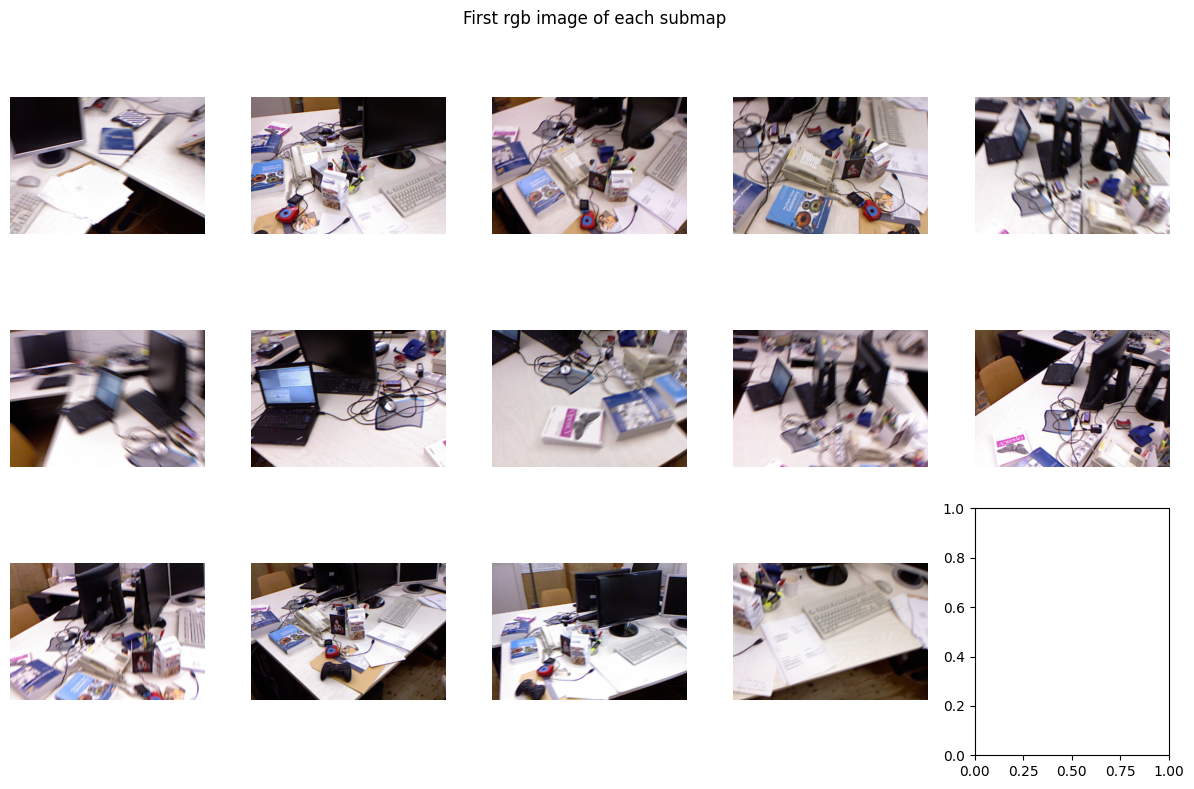

Loading estimated poses, 592 poses are loaded.


In [6]:
# load dataset (rgb image, depth iamge, ground truth pose)
config = load_config("/content/drive/MyDrive/files/tumrgbd_fr1_desk/configs/TUM_RGBD/rgbd_dataset_freiburg1_desk.yaml")
dataset = get_dataset(config['dataset_name'])({**config["data"], **config["cam"]})
print(f"There are {len(dataset)} images in this scene")

# read submap check points and generate point clouds
submaps_path = '/content/drive/MyDrive/files/tumrgbd_fr1_desk'
submaps = []
submap_first_idx = [] # index of global keyframes in each submap
submap_last_idx = []
submap_first_rgbs= [] # rgb image of global keyframes in each submap
for idx in range(14):
    submaps.append(load_gaussian_ckpt(idx, submaps_path, device='cpu'))
    submap_first_idx.append(submaps[idx]['submap_keyframes'][0])
    submap_last_idx.append(submaps[idx]['submap_keyframes'][-1])
    submap_first_rgbs.append(dataset[submap_first_idx[idx]][1])
    print(f"Submap_{idx} has {submaps[idx]['gaussian_params']['xyz'].shape[0]} Gaussians")

fig, axes = plt.subplots(3, 5, figsize=(12, 8))
axes = axes.flatten()
for img, ax in zip(submap_first_rgbs, axes):
    img = np.clip(img, 0, 255)
    ax.imshow(img)
    ax.axis('off')
plt.suptitle("First rgb image of each submap")
plt.tight_layout()
plt.show()

# load estimated pose
estimated_poses_path = '/content/drive/MyDrive/files/tumrgbd_fr1_desk/estimated_c2w.ckpt'
estimated_poses = torch.load(estimated_poses_path, map_location='cpu')
print(f"Loading estimated poses, {estimated_poses.shape[0]} poses are loaded.")

In [7]:
lc_detector = LoopClosureDetector(config['loop_closure'])
min_scores = [0.757568359375,
              0.8025367259979248,
              0.855719268321991,
              0.8498480916023254,
              0.8571802377700806,
              0.80406254529953,
              0.7972279787063599,
              0.8508976101875305,
              0.8715168833732605,
              0.8666331768035889,
              0.8664165735244751,
              0.8493101596832275,
              0.8057730197906494,
              0.8318517208099365]
loop_dict = {}

for i in range(len(submap_first_rgbs)):
    if i == 0 or i == 1:
        lc_detector.add_to_index(np2torch(submap_first_rgbs[i]).permute(2, 0, 1))
    else:
        _, loop_list = lc_detector.detect_knn(np2torch(submap_first_rgbs[i]).permute(2, 0, 1), filter_threshold=min_scores[i])
        loop_dict[i] = loop_list
print(loop_dict)

# del lc_detector
# gc.collect()
# torch.cuda.empty_cache()

/usr/local/lib/python3.10/dist-packages/faiss/contrib/torch_utils.py:51: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  x.storage().data_ptr() + x.storage_offset() * 4)


{2: [], 3: [], 4: [], 5: [2, 3, 0], 6: [4, 3, 2], 7: [2, 3, 4], 8: [4, 3, 5], 9: [3], 10: [8, 2, 3, 4], 11: [2, 3, 8], 12: [10, 5, 6], 13: [2, 0, 7]}


In [8]:
# @title
def preprocess_point_cloud(
        pcd: o3d.geometry.PointCloud,
        voxel_size=0.05
    ) -> Tuple[o3d.geometry.PointCloud, o3d.pipelines.registration.Feature]:
    """ Downsample the given point cloud, estimate normals, then compute a FPFH feature for each point
    Args:
        pcd: input point cloud
        voxel_size: size of voxels, inside which only one point will be sampled
    Return:
        pcd_down: down-sampled point cloud
    """
    print(f"Downsample point cloud with a voxel size {voxel_size}.")
    pcd_down = pcd.voxel_down_sample(voxel_size)

    radius_normal = voxel_size * 2
    print(f"Estimate normal with search radius {radius_normal}.")
    pcd_down.estimate_normals(o3d.geometry.KDTreeSearchParamHybrid(radius=radius_normal, max_nn=30))

    # radius_feature = voxel_size * 5
    # print(f"Compute FPFH feature with search radius {radius_feature}.")
    # pcd_fpfh = o3d.pipelines.registration.compute_fpfh_feature(
    #     pcd_down,
    #     o3d.geometry.KDTreeSearchParamHybrid(radius=radius_feature, max_nn=100))
    # return pcd_down, pcd_fpfh
    return pcd_down


def compute_relative_pose(
        source_pcl: o3d.geometry.PointCloud, # with greater index
        target_pcl: o3d.geometry.PointCloud, # with smaller index
        current_transformation: np.ndarray=None,
        voxel_size=0.05
    ) -> np.ndarray:
    """
    Caluculate the relative pose between two cameras using mean positions of Gaussian clouds
    inside the camera frustum, following a corse-to-fine process.
    Args:
        depth_map_i, depth_map_j: ground truth depth map of the current keyframe, used to
            determine the near an far plane of the frustum
        pose_i, pose_j: camera pose of the current keyframe
        gaussians_i, gaussians_j: gaussian clouds for registration
        intrinsics: camera intrinsic matrix of the dataset
        voxel_size: voxel size for point cloud down sampling
    Returns:
        relative pose between two keyframes
    """
    # source_down, source_fpfh = preprocess_point_cloud(source_pcl, voxel_size)
    # target_down, target_fpfh = preprocess_point_cloud(target_pcl, voxel_size)
    source_down = preprocess_point_cloud(source_pcl, voxel_size)
    target_down = preprocess_point_cloud(target_pcl, voxel_size)

    # use Point-to-plane ICP to further refine the alignment
    distance_threshold_local = voxel_size * 0.4
    icp_pose = o3d.pipelines.registration.registration_icp(
        source_down, target_down, distance_threshold_local, current_transformation,
        o3d.pipelines.registration.TransformationEstimationPointToPlane())
    print(icp_pose)
    return icp_pose.transformation, np.asarray(icp_pose.correspondence_set)

In [19]:
def build_rotation(r):
    # batch operation supported
    q = F.normalize(r, p=2, dim=-1)

    w = q[..., 0]
    x = q[..., 1]
    y = q[..., 2]
    z = q[..., 3]

    R = torch.stack(
        [1 - 2 * (y*y + z*z), 2 * (x*y - w*z), 2 * (x*z + w*y),
         2 * (x*y + w*z), 1 - 2 * (x*x + z*z), 2 * (y*z - w*x),
         2 * (x*z - w*y), 2 * (y*z + w*x), 1 - 2 * (x*x + y*y)], dim=-1
        ).view(*q.shape[:-1], 3, 3).to('cuda') # TODO: to cuda
    return R


def build_scaling_rotation(s, r):
    # L = torch.zeros((s.shape[0:-1]+(3, 3)), dtype=torch.float, device="cuda")
    # L = torch.zeros_like(s[..., :3, None]) @ torch.zeros_like(s[..., None, :3])
    L = torch.diag_embed(s).to('cuda') # TODO: to cuda
    R = build_rotation(r)

    L = R @ L
    return L


def modified_sigmoid(tensor: torch.Tensor, k=3) -> torch.Tensor:
    """ A modified version of sigmoid function which only accepts non-negative inputs, and return values are limited
    between 0 and 1. Modify k to get different curvatures """
    return 2 / (1 + torch.exp(k * tensor))


def quaternion_multiplication(q1: torch.Tensor, q2: torch.Tensor) -> torch.Tensor:
    """Quaternion multiplication q1 * q2, supporting broadcasting """
    q1_w, q1_x, q1_y, q1_z = q1[..., 0], q1[..., 1], q1[..., 2], q1[..., 3]
    q2_w, q2_x, q2_y, q2_z = q2[..., 0], q2[..., 1], q2[..., 2], q2[..., 3]

    w = q1_w * q2_w - q1_x * q2_x - q1_y * q2_y - q1_z * q2_z
    x = q1_w * q2_x + q1_x * q2_w + q1_y * q2_z - q1_z * q2_y
    y = q1_w * q2_y - q1_x * q2_z + q1_y * q2_w + q1_z * q2_x
    z = q1_w * q2_z + q1_x * q2_y - q1_y * q2_x + q1_z * q2_w

    return torch.stack((w, x, y, z), dim=-1)


def hellinger_distance(gaussian_xyz_i:torch.Tensor, gaussian_scaling_i: torch.Tensor, gaussian_rotation_i: torch.Tensor,
                       gaussian_xyz_j:torch.Tensor, gaussian_scaling_j: torch.Tensor, gaussian_rotation_j: torch.Tensor
) -> torch.Tensor:
    def build_covariance_from_scaling_rotation(scaling, scaling_modifier, rotation):
        L = build_scaling_rotation(scaling_modifier * scaling, rotation)
        return L @ L.transpose(-2, -1)

    device = gaussian_scaling_i.device
    gaussian_covariance_i = build_covariance_from_scaling_rotation(gaussian_scaling_i, 1, gaussian_rotation_i).to(device) # (batch_size, num_gs, 3, 3)
    gaussian_covariance_j = build_covariance_from_scaling_rotation(gaussian_scaling_j, 1, gaussian_rotation_j).to(device)

    gaussian_covariance_mean = (gaussian_covariance_i + gaussian_covariance_j) / 2 # (batch_size, num_gs, 3, 3)
    det_gaussian_covariance_i = torch.linalg.det(gaussian_covariance_i) # (batch_size, num_gs)
    det_gaussian_covariance_j = torch.linalg.det(gaussian_covariance_j) # (batch_size, num_gs)
    det_gaussian_covariance_mean = torch.linalg.det(gaussian_covariance_mean) # (batch_size, num_gs)

    gaussian_xyz_diff = (gaussian_xyz_i - gaussian_xyz_j).unsqueeze(-1) # (batch_size, num_gs, 3, 1）
    coefficient = det_gaussian_covariance_i.pow(1/4) * det_gaussian_covariance_j.pow(1/4) / det_gaussian_covariance_mean.pow(1/2) # (batch_size, num_gs)
    power = -1/8 * gaussian_xyz_diff.transpose(-2, -1) @ gaussian_covariance_mean.inverse() @ gaussian_xyz_diff # (batch_size, num_gs, 1, 1)
    h_distance = 1 - coefficient * torch.exp(power.squeeze())
    return h_distance

In [30]:
import random

def to_skew_symmetric(tensor: torch.Tensor):
    tensor_shape = tensor.shape
    if len(tensor_shape) > 3 or tensor_shape[-1] != 3:
        raise ValueError("Incorrect tensor dimension!")

    if len(tensor_shape) == 1:
        skew_symmetric = tensor.new_zeros((1, )+tensor_shape+(3, ))
    else:
        skew_symmetric = tensor.new_zeros(tensor_shape+(3, ))

    skew_symmetric[..., 0, 1] = -tensor[..., 2]
    skew_symmetric[..., 0, 2] = tensor[..., 1]
    skew_symmetric[..., 1, 0] = tensor[..., 2]
    skew_symmetric[..., 1, 2] = -tensor[..., 0]
    skew_symmetric[..., 2, 0] = -tensor[..., 1]
    skew_symmetric[..., 2, 1] = tensor[..., 0]

    return skew_symmetric


# def downsample(container, num_samples):
#     num_before = len(container)
#     if num_before <= num_samples:
#         return container
#     else:
#         return random.sample(container, num_samples)

def downsample(container, num_samples):
    num_before = len(container)
    if num_before <= num_samples:
        return list(range(0, num_before))
    else:
        return random.sample(range(0, num_before), num_samples)


class GaussianSLAMEdge:
    def __init__(
        self,
        vertex_idx_i: int,
        vertex_idx_j: int,
        relative_pose: torch.Tensor,
        cost_weight=1.0,
        device='cpu'
    ):
        self.device = device
        self.vertex_idx_i = vertex_idx_i
        self.vertex_idx_j = vertex_idx_j
        self.relative_pose = th.SE3(
            tensor=relative_pose.squeeze().unsqueeze(0)[:, :3, :],
            name=f'EDGE_SE3__{str(vertex_idx_i).zfill(6)}_{str(vertex_idx_j).zfill(6)}'
        )
        self.relative_pose.to(self.device)
        self.cost_weight = th.ScaleCostWeight(
            scale=cost_weight,
            name=f"EDGE_WEIGHT__{str(vertex_idx_i).zfill(6)}_{str(vertex_idx_j).zfill(6)}"
        )
        self.cost_weight.to(self.device)


class GaussianSLAMPoseGraph:

    def __init__(self, config: Dict, device='cpu', requires_auto_grad=True):
        self._requires_auto_grad = requires_auto_grad
        self.device = device
        self.objective = th.Objective()
        self.objective.to(self.device)
        self.center_matching_threshold = config["center_matching_threshold"]
        self.optimization_max_iterations = config["optimization_max_iterations"]
        self.optimization_step_size = config["optimization_step_size"]
        self.loop_inlier_threshold = config["loop_inlier_threshold"]
        self.correspondence_factor = config["correspondence_factor"]
        self.damping = config["damping"]
        self.track_best_solution = config["track_best_solution"]
        self.verbose = config["verbose"]

    def add_odometry_edge_new(
            self,
            vertex_i: th.SE3,
            vertex_j: th.SE3,
            edge: GaussianSLAMEdge,
            gaussian_xyz_i: torch.Tensor,
            gaussian_scaling_i: torch.Tensor,
            gaussian_rotation_i: torch.Tensor,
            gaussian_color_i: torch.Tensor,
            gaussian_scaling_j: torch.Tensor,
            gaussian_rotation_j: torch.Tensor,
            gaussian_color_j: torch.Tensor
        ):

        vertex_i.to(self.device)
        vertex_j.to(self.device)

        num_matches = gaussian_xyz_i.shape[0]
        gaussian_xyz_i_th = th.Variable(tensor=gaussian_xyz_i.unsqueeze(0)) # (1, num_gs, 3)
        gaussian_scaling_i_th = th.Variable(tensor=gaussian_scaling_i.unsqueeze(0)) # (1, num_gs, 3)
        gaussian_rotation_i_th = th.Variable(tensor=gaussian_rotation_i.unsqueeze(0)) # (1, num_gs, 4)
        gaussian_color_i_th = th.Variable(tensor=gaussian_color_i.unsqueeze(0)) # (1, num_gs, 3)

        gaussian_xyz_i_th.to(self.device)
        gaussian_scaling_i_th.to(self.device)
        gaussian_rotation_i_th.to(self.device)
        gaussian_color_i_th.to(self.device)

        gaussian_scaling_j_th = th.Variable(tensor=gaussian_scaling_j.unsqueeze(0))
        gaussian_rotation_j_th = th.Variable(tensor=gaussian_rotation_j.unsqueeze(0))
        gaussian_color_j_th = th.Variable(tensor=gaussian_color_j.unsqueeze(0))

        gaussian_scaling_j_th.to(self.device)
        gaussian_rotation_j_th.to(self.device)
        gaussian_color_j_th.to(self.device)

        if self._requires_auto_grad:
            cost_fn = th.AutoDiffCostFunction(
                optim_vars=[vertex_i, vertex_j],
                err_fn=GaussianSLAMPoseGraph.error_fn_dense_gaussian_alignment,
                dim=num_matches,
                cost_weight=edge.cost_weight,
                aux_vars=[edge.relative_pose, gaussian_xyz_i_th, gaussian_scaling_i_th, gaussian_rotation_i_th, gaussian_color_i_th,
                                                                 gaussian_scaling_j_th, gaussian_rotation_j_th, gaussian_color_j_th],
                name=f"COST_FUNCTION_REGISTRATION__{str(edge.vertex_idx_i).zfill(6)}_{str(edge.vertex_idx_j).zfill(6)}"
            )
            self.objective.add(cost_fn)
        else:
            raise NotImplementedError()

    def add_loop_closure_edge_new(
            self,
            vertex_i: th.SE3,
            vertex_j: th.SE3,
            edge: GaussianSLAMEdge,
            gaussian_xyz_i: torch.Tensor,
            gaussian_scaling_i: torch.Tensor,
            gaussian_rotation_i: torch.Tensor,
            gaussian_color_i: torch.Tensor,
            gaussian_scaling_j: torch.Tensor,
            gaussian_rotation_j: torch.Tensor,
            gaussian_color_j: torch.Tensor
        ) -> None:

        vertex_i.to(self.device)
        vertex_j.to(self.device)
        l_ij = th.Vector(
            tensor=torch.ones(1, 1),
            name=f"LINE_PROCESS__{str(edge.vertex_idx_i).zfill(6)}_{str(edge.vertex_idx_j).zfill(6)}"
        )
        l_ij.to(self.device)
        num_matches = gaussian_xyz_i.shape[0]
        gaussian_xyz_i_th = th.Variable(tensor=gaussian_xyz_i.unsqueeze(0)) # (1, num_gs, 3)
        gaussian_scaling_i_th = th.Variable(tensor=gaussian_scaling_i.unsqueeze(0)) # (1, num_gs, 3)
        gaussian_rotation_i_th = th.Variable(tensor=gaussian_rotation_i.unsqueeze(0)) # (1, num_gs, 4)
        gaussian_color_i_th = th.Variable(tensor=gaussian_color_i.unsqueeze(0)) # (1, num_gs, 3)

        gaussian_xyz_i_th.to(self.device)
        gaussian_scaling_i_th.to(self.device)
        gaussian_rotation_i_th.to(self.device)
        gaussian_color_i_th.to(self.device)

        gaussian_scaling_j_th = th.Variable(tensor=gaussian_scaling_j.unsqueeze(0))
        gaussian_rotation_j_th = th.Variable(tensor=gaussian_rotation_j.unsqueeze(0))
        gaussian_color_j_th = th.Variable(tensor=gaussian_color_j.unsqueeze(0))

        gaussian_scaling_j_th.to(self.device)
        gaussian_rotation_j_th.to(self.device)
        gaussian_color_j_th.to(self.device)


        cost_weight_registration = edge.cost_weight # for dense surface alignment
        cost_weight_mu = cost_weight_registration.scale.tensor.squeeze() * np.sqrt(num_matches) * self.correspondence_factor
        cost_weight_line_process = th.ScaleCostWeight(cost_weight_mu) # for line process

        cost_weight_registration.to(self.device)
        cost_weight_line_process.to(self.device)

        if self._requires_auto_grad:
            cost_fn_registration = th.AutoDiffCostFunction(
                optim_vars=[vertex_i, vertex_j, l_ij],
                err_fn=GaussianSLAMPoseGraph.error_fn_dense_gaussian_alignment,
                dim=num_matches,
                cost_weight=cost_weight_registration,
                aux_vars=[edge.relative_pose, gaussian_xyz_i_th, gaussian_scaling_i_th, gaussian_rotation_i_th, gaussian_color_i_th,
                                                              gaussian_scaling_j_th, gaussian_rotation_j_th, gaussian_color_j_th],
                name=f"COST_FUNCTION_REGISTRATION__{str(edge.vertex_idx_i).zfill(6)}_{str(edge.vertex_idx_j).zfill(6)}"
            )
            self.objective.add(cost_fn_registration)
            cost_fn_line_process = th.AutoDiffCostFunction(
                optim_vars=[l_ij,],
                err_fn=GaussianSLAMPoseGraph.error_fn_line_process,
                dim=1,
                cost_weight=cost_weight_line_process,
                name=f"COST_FUNCTION_LINE_PROCRSS__{str(edge.vertex_idx_i).zfill(6)}_{str(edge.vertex_idx_j).zfill(6)}"
            )
            self.objective.add(cost_fn_line_process)
        else:
            raise NotImplementedError()

    def _remove_loop_outlier(self, substring="LINE_PROCESS") -> bool:
        """ Remove from objective false loops and all cost functions connect to them """
        flag = False
        for optim_key, optim_val in self.objective.optim_vars.items():
            if substring in optim_key:
                if optim_val.tensor < self.loop_inlier_threshold:
                    flag = True
                    print(f"Removing optimizaiton variable {optim_key} from objective.")
                    cost_fns = self.objective.get_functions_connected_to_optim_var(optim_val)
                    for cost_fn in cost_fns.copy():
                        print(f"Removing cost function {cost_fn.name} from objective.")
                        self.objective.erase(cost_fn.name)
        return flag

    def _optimize(self) -> th.OptimizerInfo:
        optimizer = th.LevenbergMarquardt(
            objective=self.objective,
            max_iterations=self.optimization_max_iterations,
            step_size=self.optimization_step_size,
            linearization_cls=th.SparseLinearization,
            # linearization_cls=th.DenseLinearization,
            linear_solver_cls=th.CholmodSparseSolver,
            # linear_solver_cls=th.LUDenseSolver,
            #abs_err_tolerance=1e-9,
            rel_err_tolerance=1e-4,
            # rel_err_tolerance=1e-6,
            vectorize=True,
        )
        layer = th.TheseusLayer(optimizer)
        layer.to(self.device)
        with torch.no_grad():
            _, info = layer.forward(optimizer_kwargs={
                "damping": self.damping,
                "track_best_solution": self.track_best_solution,
                "verbose": self.verbose,
                # "end_iter_callback": my_callback
            })
        return info

    def optimize_two_steps(self) -> th.OptimizerInfo:
        print(f"First step optimization, dealing with {self.objective.size_cost_functions()} cost functions")
        info = self._optimize()
        has_loop_outlier = self._remove_loop_outlier("LINE_PROCESS")
        if has_loop_outlier:
            print(f"Second step optimization, dealing with {self.objective.size_cost_functions()} cost functions")
            info = self._optimize()
        return info

    @staticmethod
    def match_gaussian_means(
            pts_1: torch.Tensor,
            pts_2: torch.Tensor,
            transformation: torch.Tensor,
            epsilon=5e-2
        ) -> Tuple[List, List]:

        rotation = transformation[:3, :3]
        translation = transformation[:3, 3]
        pts_1_new = pts_1 @ rotation.transpose(0, 1) + translation
        pts2_kdtree = KDTree(torch2np(pts_2))

        _, query_idx = pts2_kdtree.query(
            torch2np(pts_1_new),
            distance_upper_bound=epsilon,
            workers=-1
        )
        res_list_1, res_list_2 = [], []
        for i in range(query_idx.shape[0]):
            if query_idx[i] != pts_2.shape[0]:
                res_list_1.append(i)
                res_list_2.append(query_idx[i])
        print(f'{len(res_list_1)} correspondences are found before adding to pose graph.')
        return res_list_1, res_list_2

    @ staticmethod
    def error_fn_line_process(optim_vars: th.Vector, aux_vars=None) -> torch.Tensor:
        """
        Computes the line process error of a loop closrue edge, can be used as the error
        input to instantiate a th.CostFunction variable

        Args:
            optim_vars:
                l_ij: jointly optimized weight (l_ij ∈ [0, 1]) over the loop edges
                (note that the scaling factor mu is considered as cost_weight)

        Returns:
            square root of line process error
        """
        l_ij, = optim_vars
        # print(f"line process shape = {l_ij.tensor.sqrt().shape}")
        return l_ij.tensor.sqrt() - 1

    @ staticmethod
    def error_fn_dense_gaussian_alignment(
        optim_vars: Union[Tuple[th.SE3, th.SE3], Tuple[th.SE3, th.SE3, torch.Tensor]],
        aux_vars: Tuple[th.SE3, th.Variable, th.Variable, th.Variable, th.Variable, \
                                th.Variable, th.Variable, th.Variable, th.Variable]
        ) -> torch.Tensor:

        tuple_size = len(optim_vars)
        if tuple_size == 2:
            pose_i, pose_j = optim_vars
        elif tuple_size == 3:
            pose_i, pose_j, l_ij = optim_vars
        else:
            raise ValueError(f"optim_vars tuple size is {tuple_size}, which can only be 2 or 3.")

        relative_pose, gaussian_xyz_i, gaussian_scaling_i, gaussian_rotation_i, gaussian_color_i, \
                                       gaussian_scaling_j, gaussian_rotation_j, gaussian_color_j = aux_vars

        gaussian_xyz_i_corrected = gaussian_xyz_i.tensor @ pose_i.rotation().tensor.transpose(1, 2) + pose_i.translation().tensor.unsqueeze(-2)
        gaussian_rotation_i_corrected = quaternion_multiplication(pose_i.rotation().to_quaternion().unsqueeze(-2), gaussian_rotation_i.tensor)

        gaussian_xyz_j = gaussian_xyz_i.tensor @ relative_pose.rotation().tensor.transpose(1, 2) + relative_pose.translation().tensor.unsqueeze(-2)
        gaussian_xyz_j_corrected = gaussian_xyz_j @ pose_j.rotation().tensor.transpose(1, 2) + pose_j.translation().tensor.unsqueeze(-2)
        gaussian_rotation_j_corrected = quaternion_multiplication(pose_j.rotation().to_quaternion().unsqueeze(-2), gaussian_rotation_j.tensor)

        ###########################################################
        # TODO: Do I need to apply the relative pose to rotation? #
        # gaussian_rotation_i_transformed = quaternion_multiplication(relative_pose.rotation().to_quaternion().unsqueeze(-2), gaussian_rotation_i_corrected)
        ###########################################################

        h_distance = hellinger_distance(
            gaussian_xyz_i_corrected, gaussian_scaling_i.tensor, gaussian_rotation_i_corrected,
            gaussian_xyz_j_corrected, gaussian_scaling_j.tensor, gaussian_rotation_j_corrected
        ) # (batch_size, num_gs)
        color_diff = torch.norm(gaussian_color_i.tensor-gaussian_color_j.tensor, p=1, dim=-1) # (batch_size, num_gs)
        if tuple_size == 2:
            return modified_sigmoid(color_diff, k=4).sqrt() * h_distance.sqrt()
        else:
            return l_ij.tensor.sqrt() * modified_sigmoid(color_diff, k=4).sqrt() * h_distance.sqrt()



In [33]:
pose_graph = GaussianSLAMPoseGraph(config["pose_graph"])
pose_graph.optimization_step_size=0.02
pose_graph.correspondence_factor=0.5
# pose_graph.optimization_max_iterations=50
# pose_graph.verbose = True
C0 = 0.28209479177387814

for i in range(1, 14):
    print(f"Building odometry constraint between submap_{i-1} and submap{i}")
    last_start_idx = submaps[i-1]['submap_keyframes'][0]
    last_start_pose = estimated_poses[last_start_idx]
    last_frustum_corners = compute_camera_frustum_corners(dataset[last_start_idx][2], last_start_pose, dataset.intrinsics)
    last_reused_pts_ids = compute_frustum_point_ids(submaps[i-1]['gaussian_params']['xyz'], last_frustum_corners, device='cpu')

    current_start_idx = submaps[i]['submap_keyframes'][0]
    current_start_pose = estimated_poses[current_start_idx]
    current_frustum_corners = compute_camera_frustum_corners(dataset[current_start_idx][2], current_start_pose, dataset.intrinsics)
    current_reused_pts_ids = compute_frustum_point_ids(submaps[i]['gaussian_params']['xyz'], current_frustum_corners, device='cpu')

    match_idx_last, match_idx_current = GaussianSLAMPoseGraph.match_gaussian_means(
        submaps[i-1]['gaussian_params']['xyz'][last_reused_pts_ids],
        submaps[i]['gaussian_params']['xyz'][current_reused_pts_ids],
        torch.eye(4), 5e-2
    )
    downsample_idx_odometry = downsample(match_idx_last, 100) # TODO: downsample size is a hyperparamete

    # th.SE3.exp_map(torch.cat([(torch.zeros(1, 3)), 1e-2 * (2.0 * torch.rand(1, 3) - 1),],dim=1))
    if pose_graph.objective.has_optim_var(f"VERTEX_SE3__{str(i-1).zfill(6)}"):
        last_vertex = pose_graph.objective.get_optim_var(f"VERTEX_SE3__{str(i-1).zfill(6)}")
    else:
        # TODO: very poor initialization here, try to modify
        # last_vertex = th.SE3(tensor=torch.tile(torch.eye(3, 4), [1, 1, 1]), name=f"VERTEX_SE3__{str(i-1).zfill(6)}")
        last_vertex = th.SE3(tensor=th.SE3.exp_map(torch.cat([(torch.zeros(1, 3)), 2e-2 * (2.0 * torch.rand(1, 3) - 1),],dim=-1)), name=f"VERTEX_SE3__{str(i-1).zfill(6)}")
    # current_vertex = th.SE3(tensor=torch.tile(torch.eye(3, 4), [1, 1, 1]), name=f"VERTEX_SE3__{str(i).zfill(6)}")
    current_vertex = th.SE3(tensor=th.SE3.exp_map(torch.cat([(torch.zeros(1, 3)), 2e-2 * (2.0 * torch.rand(1, 3) - 1),],dim=-1)), name=f"VERTEX_SE3__{str(i).zfill(6)}")

    edge = GaussianSLAMEdge(i-1, i, torch.eye(3, 4))
    pose_graph.add_odometry_edge_new(
        last_vertex, current_vertex, edge,
        submaps[i-1]['gaussian_params']['xyz'][last_reused_pts_ids][match_idx_last][downsample_idx_odometry],
        torch.exp(submaps[i-1]['gaussian_params']['scaling'][last_reused_pts_ids][match_idx_last][downsample_idx_odometry]),
        F.normalize(submaps[i-1]['gaussian_params']['rotation'][last_reused_pts_ids][match_idx_last][downsample_idx_odometry], dim=-1),
        ((submaps[i-1]['gaussian_params']['features_dc'][last_reused_pts_ids][match_idx_last][downsample_idx_odometry])*C0+0.5).clamp(0, 1).squeeze(),
        torch.exp(submaps[i]['gaussian_params']['scaling'][current_reused_pts_ids][match_idx_current][downsample_idx_odometry]),
        F.normalize(submaps[i]['gaussian_params']['rotation'][current_reused_pts_ids][match_idx_current][downsample_idx_odometry], dim=-1),
        ((submaps[i]['gaussian_params']['features_dc'][current_reused_pts_ids][match_idx_current][downsample_idx_odometry]).squeeze()*C0+0.5).clamp(0, 1)
    )
    print(f"Current error metric = {pose_graph.objective.error_metric()}")

    loop_idx_list = loop_dict.get(i, [])
    for loop_idx in loop_idx_list:
        loop_vertex = pose_graph.objective.get_optim_var(f"VERTEX_SE3__{str(loop_idx).zfill(6)}")
        loop_start_idx = submaps[loop_idx]['submap_keyframes'][0]
        loop_start_pose = estimated_poses[loop_start_idx]
        loop_frustum_corners = compute_camera_frustum_corners(dataset[loop_start_idx][2], loop_start_pose, dataset.intrinsics)
        loop_reused_pts_ids = compute_frustum_point_ids(submaps[loop_idx]['gaussian_params']['xyz'], loop_frustum_corners, device='cpu')

        rel_pose, correspondence_set = compute_relative_pose(
            np2ptcloud(torch2np(submaps[loop_idx]['gaussian_params']['xyz'][loop_reused_pts_ids])),
            np2ptcloud(torch2np(submaps[i]['gaussian_params']['xyz'][current_reused_pts_ids])),
            np.eye(4)
        )
        print(f"rel_pose = {rel_pose}")
        edge_loop = GaussianSLAMEdge(loop_idx, i, np2torch(rel_pose), 1.0)

        # skip for wrong match
        if len(correspondence_set) > 0:
            print(f"Building loop constraint between submap_{i} and submap_{loop_idx}")
            # downsample_idx_loop = downsample(correspondence_set[:, 0], 100)

            pose_graph.add_loop_closure_edge_new(
                loop_vertex, current_vertex, edge_loop,
                submaps[loop_idx]['gaussian_params']['xyz'][loop_reused_pts_ids][correspondence_set[:, 0]],
                torch.exp(submaps[loop_idx]['gaussian_params']['scaling'][loop_reused_pts_ids][correspondence_set[:, 0]]),
                F.normalize(submaps[loop_idx]['gaussian_params']['rotation'][loop_reused_pts_ids][correspondence_set[:, 0]], dim=-1),
                ((submaps[loop_idx]['gaussian_params']['features_dc'][loop_reused_pts_ids][correspondence_set[:, 0]])*C0+0.5).clamp(0, 1).squeeze(),
                torch.exp(submaps[i]['gaussian_params']['scaling'][current_reused_pts_ids][correspondence_set[:, 1]]),
                F.normalize(submaps[i]['gaussian_params']['rotation'][current_reused_pts_ids][correspondence_set[:, 1]], dim=-1),
                ((submaps[i]['gaussian_params']['features_dc'][current_reused_pts_ids][correspondence_set[:, 1]])*C0+0.5).clamp(0, 1).squeeze()
            )
            print(f"Current error metric = {pose_graph.objective.error_metric()}")
            info = pose_graph._optimize()
            print(info)


pose_correct_0 = pose_graph.objective.get_optim_var(f"VERTEX_SE3__{str(0).zfill(6)}").to_matrix().squeeze().detach().to('cpu')
for i in range(1, 6):
    submap_i_start_idx = submaps[i]['submap_keyframes'][0]
    submap_i_end_idx = submaps[i]['submap_keyframes'][-1]
    pose_gt = np2torch(dataset[submap_i_start_idx][-1])
    rot_gt = pose_gt[0:3, 0:3]
    trans_gt = pose_gt[0:3, 3]

    pose_est = estimated_poses[submap_i_start_idx]
    rot_est = pose_est[0:3, 0:3]
    trans_est = pose_est[0:3, 3]

    pose_correct = pose_graph.objective.get_optim_var(f"VERTEX_SE3__{str(i).zfill(6)}").to_matrix().squeeze().detach().to('cpu')
    pose_correct = pose_correct_0.inverse() @ pose_correct
    pose_opt = pose_correct @ pose_est
    rot_opt = pose_opt[0:3, 0:3]
    trans_opt = pose_opt[0:3, 3]

    print(f"Rotation error before: {torch.acos((torch.trace(torch.matmul(rot_est.t(), rot_gt)) - 1) / 2)}, after: {torch.acos((torch.trace(torch.matmul(rot_opt.t(), rot_gt)) - 1) / 2)} \n\
        Translation error before: {(trans_est.t() @ trans_gt).sqrt()}, after: {(trans_opt.t() @ trans_gt).sqrt()}")


Building odometry constraint between submap_0 and submap1
1949 correspondences are found before adding to pose graph.
Current error metric = tensor([20.3444])
Building odometry constraint between submap_1 and submap2
23091 correspondences are found before adding to pose graph.
Current error metric = tensor([47.5891])
Building odometry constraint between submap_2 and submap3
26357 correspondences are found before adding to pose graph.
Current error metric = tensor([69.3581])
Building odometry constraint between submap_3 and submap4
22564 correspondences are found before adding to pose graph.
Current error metric = tensor([86.6598])
Building odometry constraint between submap_4 and submap5
16406 correspondences are found before adding to pose graph.
Current error metric = tensor([106.6170])
Downsample point cloud with a voxel size 0.05.
Estimate normal with search radius 0.1.
Downsample point cloud with a voxel size 0.05.
Estimate normal with search radius 0.1.
RegistrationResult with fi

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Error detected in SqrtBackward0. Traceback of forward call that caused the error:
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
    self._run_once()
  File "/usr/lib/py

RuntimeError: Function 'SqrtBackward0' returned nan values in its 0th output.

In [34]:
pose_correct_0 = pose_graph.objective.get_optim_var(f"VERTEX_SE3__{str(0).zfill(6)}").to_matrix().squeeze().detach().to('cpu')
for i in range(1, 7):
    submap_i_start_idx = submaps[i]['submap_keyframes'][0]
    submap_i_end_idx = submaps[i]['submap_keyframes'][-1]
    pose_gt = np2torch(dataset[submap_i_start_idx][-1])
    rot_gt = pose_gt[0:3, 0:3]
    trans_gt = pose_gt[0:3, 3]

    pose_est = estimated_poses[submap_i_start_idx]
    rot_est = pose_est[0:3, 0:3]
    trans_est = pose_est[0:3, 3]

    pose_correct = pose_graph.objective.get_optim_var(f"VERTEX_SE3__{str(i).zfill(6)}").to_matrix().squeeze().detach().to('cpu')
    pose_correct = pose_correct_0.inverse() @ pose_correct
    pose_opt = pose_correct @ pose_est
    rot_opt = pose_opt[0:3, 0:3]
    trans_opt = pose_opt[0:3, 3]

    print(f"Rotation error before: {torch.acos((torch.trace(torch.matmul(rot_est.t(), rot_gt)) - 1) / 2)}, after: {torch.acos((torch.trace(torch.matmul(rot_opt.t(), rot_gt)) - 1) / 2)} \n\
        Translation error before: {(trans_est.t() @ trans_gt).sqrt()}, after: {(trans_opt.t() @ trans_gt).sqrt()}")

Rotation error before: 0.02385649085044861, after: 0.041012685745954514 
        Translation error before: 0.5170155763626099, after: 0.5230870246887207
Rotation error before: 0.028805451467633247, after: 0.03269807621836662 
        Translation error before: 0.9591183066368103, after: 0.9663694500923157
Rotation error before: 0.0273446012288332, after: 0.022798575460910797 
        Translation error before: 1.302649736404419, after: 1.3119322061538696
Rotation error before: 0.04614344239234924, after: 0.04445871338248253 
        Translation error before: 1.6688593626022339, after: 1.6783719062805176
Rotation error before: 0.03112894669175148, after: 0.043534472584724426 
        Translation error before: 1.8404165506362915, after: 1.8478360176086426
Rotation error before: 0.015882447361946106, after: 0.03529345616698265 
        Translation error before: 2.0943307876586914, after: 2.099853754043579
